In [2]:
import pandas as pd

# Cargar CSV
df = pd.read_csv("estacion1.csv")  # <- reemplaza con tu ruta real

# Mostrar las primeras filas
print("Primeras filas del dataset:")
display(df.head())

# Dimensiones del dataset
print("\nForma del dataset (filas, columnas):", df.shape)

# Nombre de las columnas
print("\nColumnas:", df.columns.tolist())


Primeras filas del dataset:


,id,estacion,sensor_name,sensor_dato,fecha
0,1,Estacion_01,Temp_CPU,51.1,2024-11-28 09:30:15
1,2,Estacion_01,Direccion del Viento,N,2024-11-28 09:30:15
2,3,Estacion_01,Radiacion UV,0.0,2024-11-28 09:30:15
3,4,Estacion_01,CO2,659.4,2024-11-28 09:30:15
4,5,Estacion_01,Anenometro,0.0,2024-11-28 09:30:15



Forma del dataset (filas, columnas): (485590, 5)

Columnas: ['id', 'estacion', 'sensor_name', 'sensor_dato', 'fecha']


In [3]:
# Revisar tipos de datos
print("\nTipos de datos:")
print(df.dtypes)

# Revisar si hay valores únicos esperados en sensor_name
print("\nSensores únicos detectados:")
print(df['sensor_name'].unique())

# Convertir columna 'fecha' a tipo datetime (si no lo está)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Confirmar conversión
print("\nTipo de dato de 'fecha' después de convertir:")
print(df['fecha'].dtype)

# Verificar si hubo problemas en la conversión (valores nulos)
print("\nValores nulos en 'fecha':", df['fecha'].isnull().sum())



Tipos de datos:
id              int64
estacion       object
sensor_name    object
sensor_dato    object
fecha          object
dtype: object

Sensores únicos detectados:
['Temp_CPU' 'Direccion del Viento' 'Radiacion UV' 'CO2' 'Anenometro'
 'Lluvia' 'Particula 10um' 'Particulas 2.5um' 'Particulas 1um' 'Luz'
 'Temperatura' 'Humedad' 'Altitud' 'Presion']

Tipo de dato de 'fecha' después de convertir:
datetime64[ns]

Valores nulos en 'fecha': 0


In [4]:
# Ver cuántos tipos únicos hay por sensor (para ver si es categórico o no)
print("\nConteo de valores únicos por sensor:")
print(df.groupby("sensor_name")["sensor_dato"].nunique())

# Intentamos convertir a numérico (los errores se vuelven NaN)
df['sensor_valor'] = pd.to_numeric(df['sensor_dato'], errors='coerce')

# Ver cuántos se pudieron convertir a numérico
num_convertidos = df['sensor_valor'].notnull().sum()
total = len(df)
print(f"\nValores numéricos detectados: {num_convertidos} de {total} totales")



Conteo de valores únicos por sensor:
sensor_name
Altitud                  1348
Anenometro               1213
CO2                      5113
Direccion del Viento        8
Humedad                   940
Lluvia                   1008
Luz                     11571
Particula 10um           1379
Particulas 1um           1009
Particulas 2.5um         1051
Presion                   160
Radiacion UV             2458
Temp_CPU                   84
Temperatura               307
Name: sensor_dato, dtype: int64

Valores numéricos detectados: 450905 de 485590 totales


In [5]:
# Dataset de sensores numéricos
df_num = df[df['sensor_valor'].notnull()].copy()

# Dataset de sensores categóricos
df_cat = df[df['sensor_valor'].isnull()].copy()

# Verificación
print("Sensores numéricos:", df_num['sensor_name'].unique())
print("Sensores categóricos:", df_cat['sensor_name'].unique())


Sensores numéricos: ['Temp_CPU' 'Radiacion UV' 'CO2' 'Anenometro' 'Lluvia' 'Particula 10um'
 'Particulas 2.5um' 'Particulas 1um' 'Luz' 'Temperatura' 'Humedad'
 'Altitud' 'Presion']
Sensores categóricos: ['Direccion del Viento']


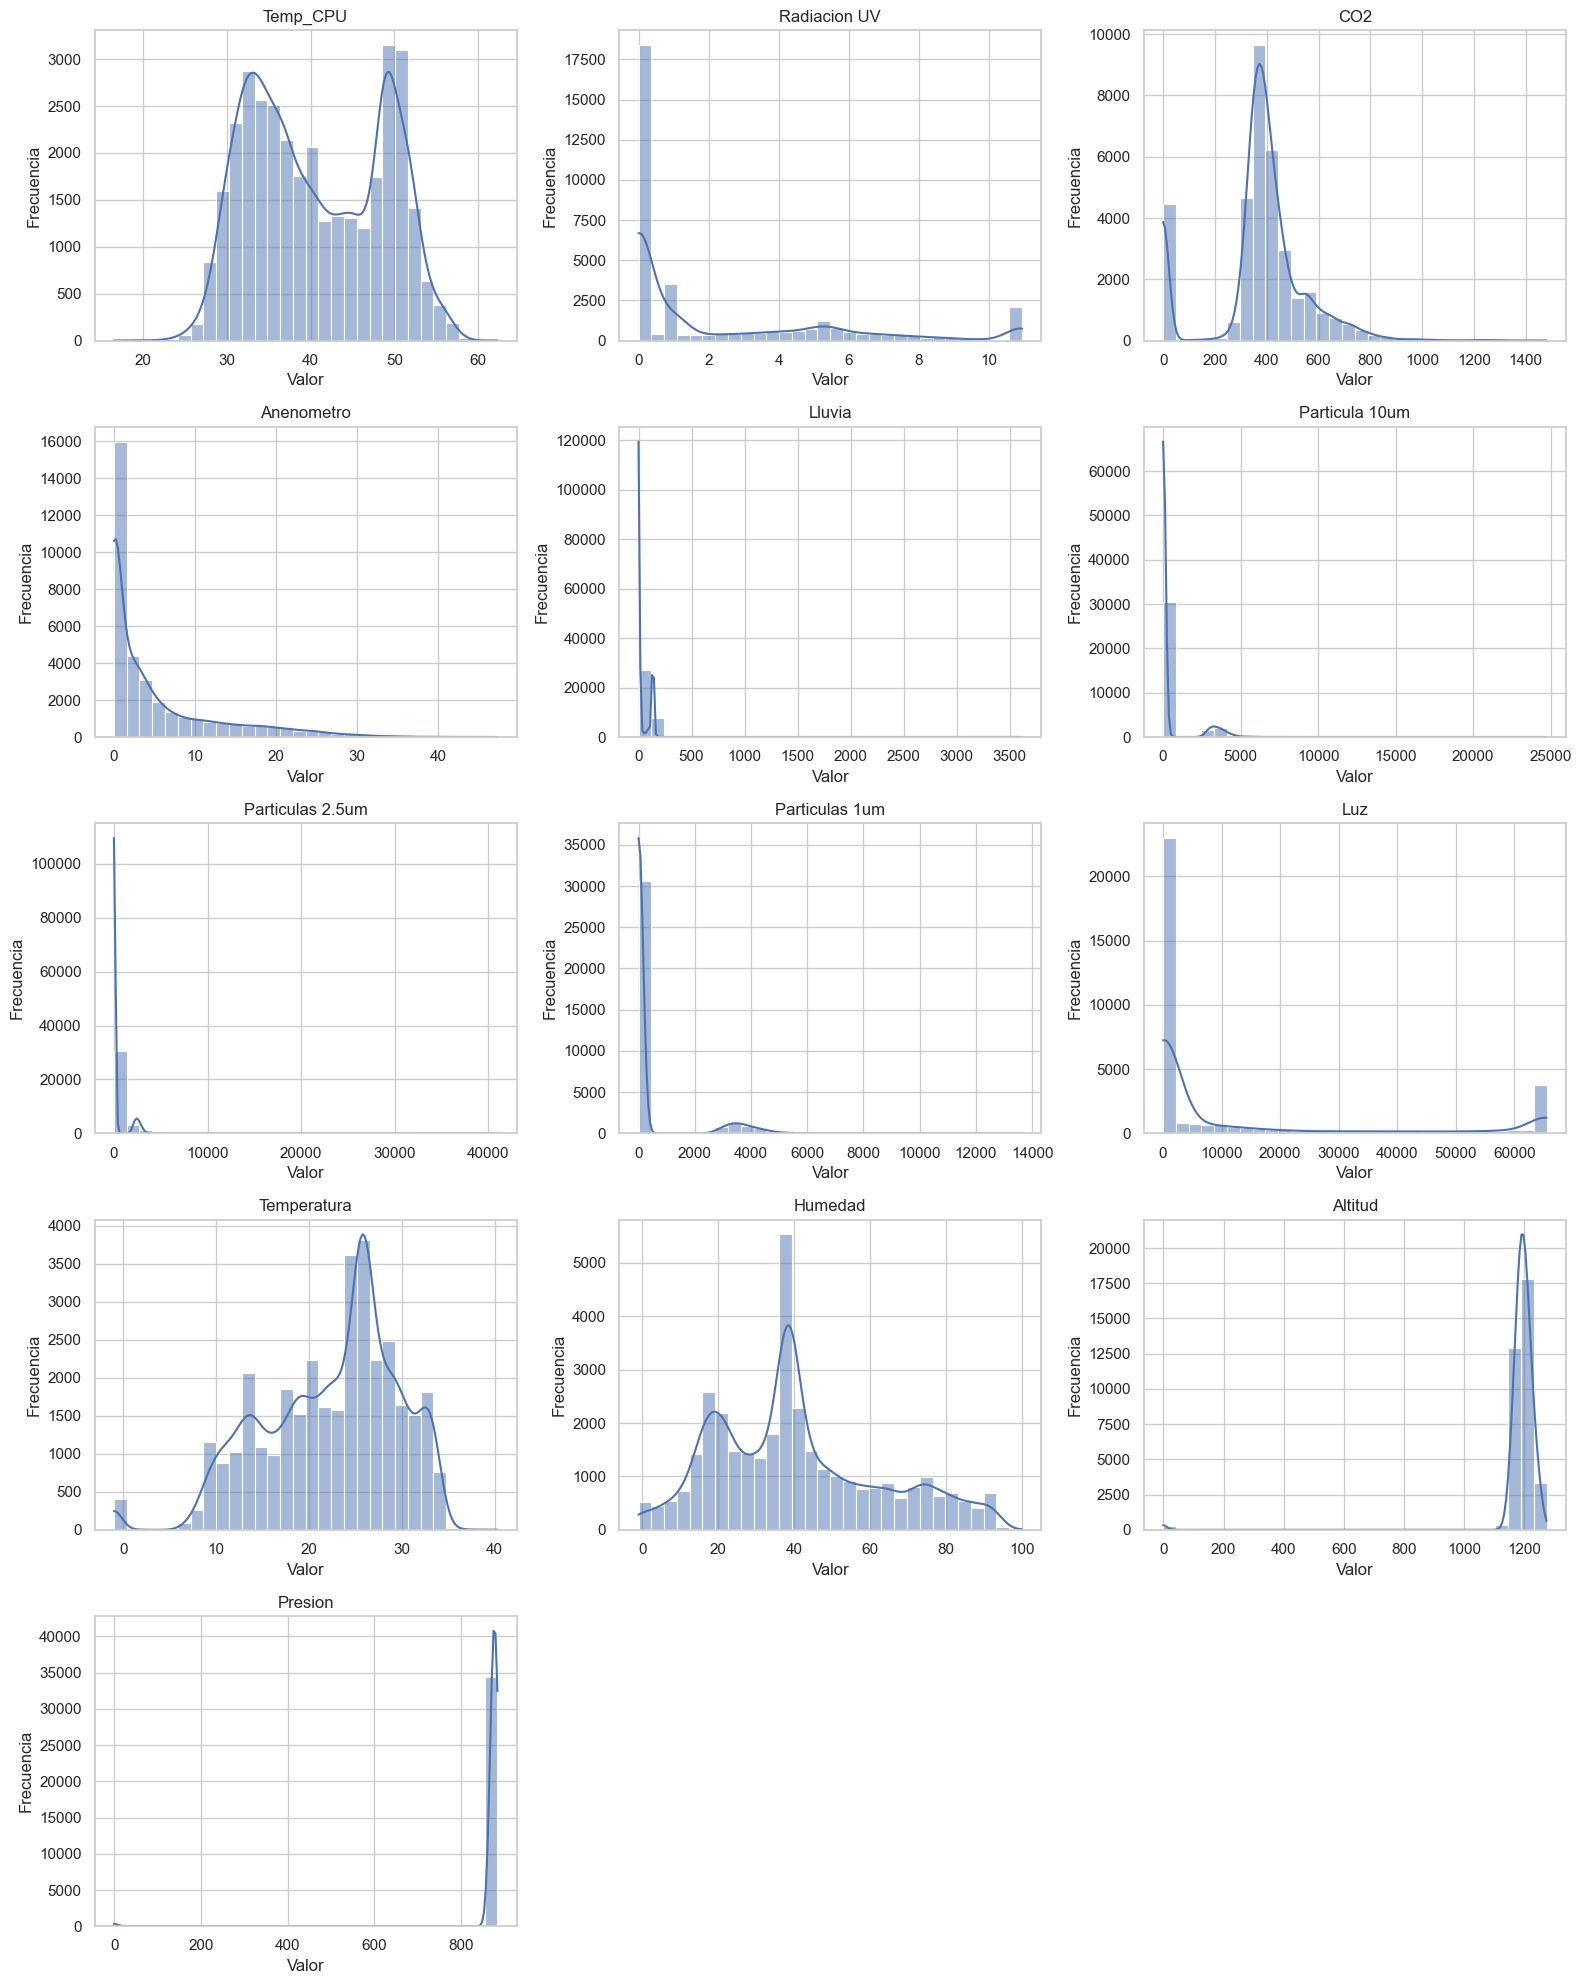

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajustes gráficos
sns.set(style="whitegrid")
plt.figure(figsize=(16, 20))

# Obtenemos todos los sensores numéricos únicos
sensores_numericos = df_num['sensor_name'].unique()

# Graficamos histogramas
for i, sensor in enumerate(sensores_numericos, 1):
    plt.subplot((len(sensores_numericos) + 2) // 3, 3, i)
    sns.histplot(df_num[df_num['sensor_name'] == sensor]['sensor_valor'], bins=30, kde=True)
    plt.title(sensor)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


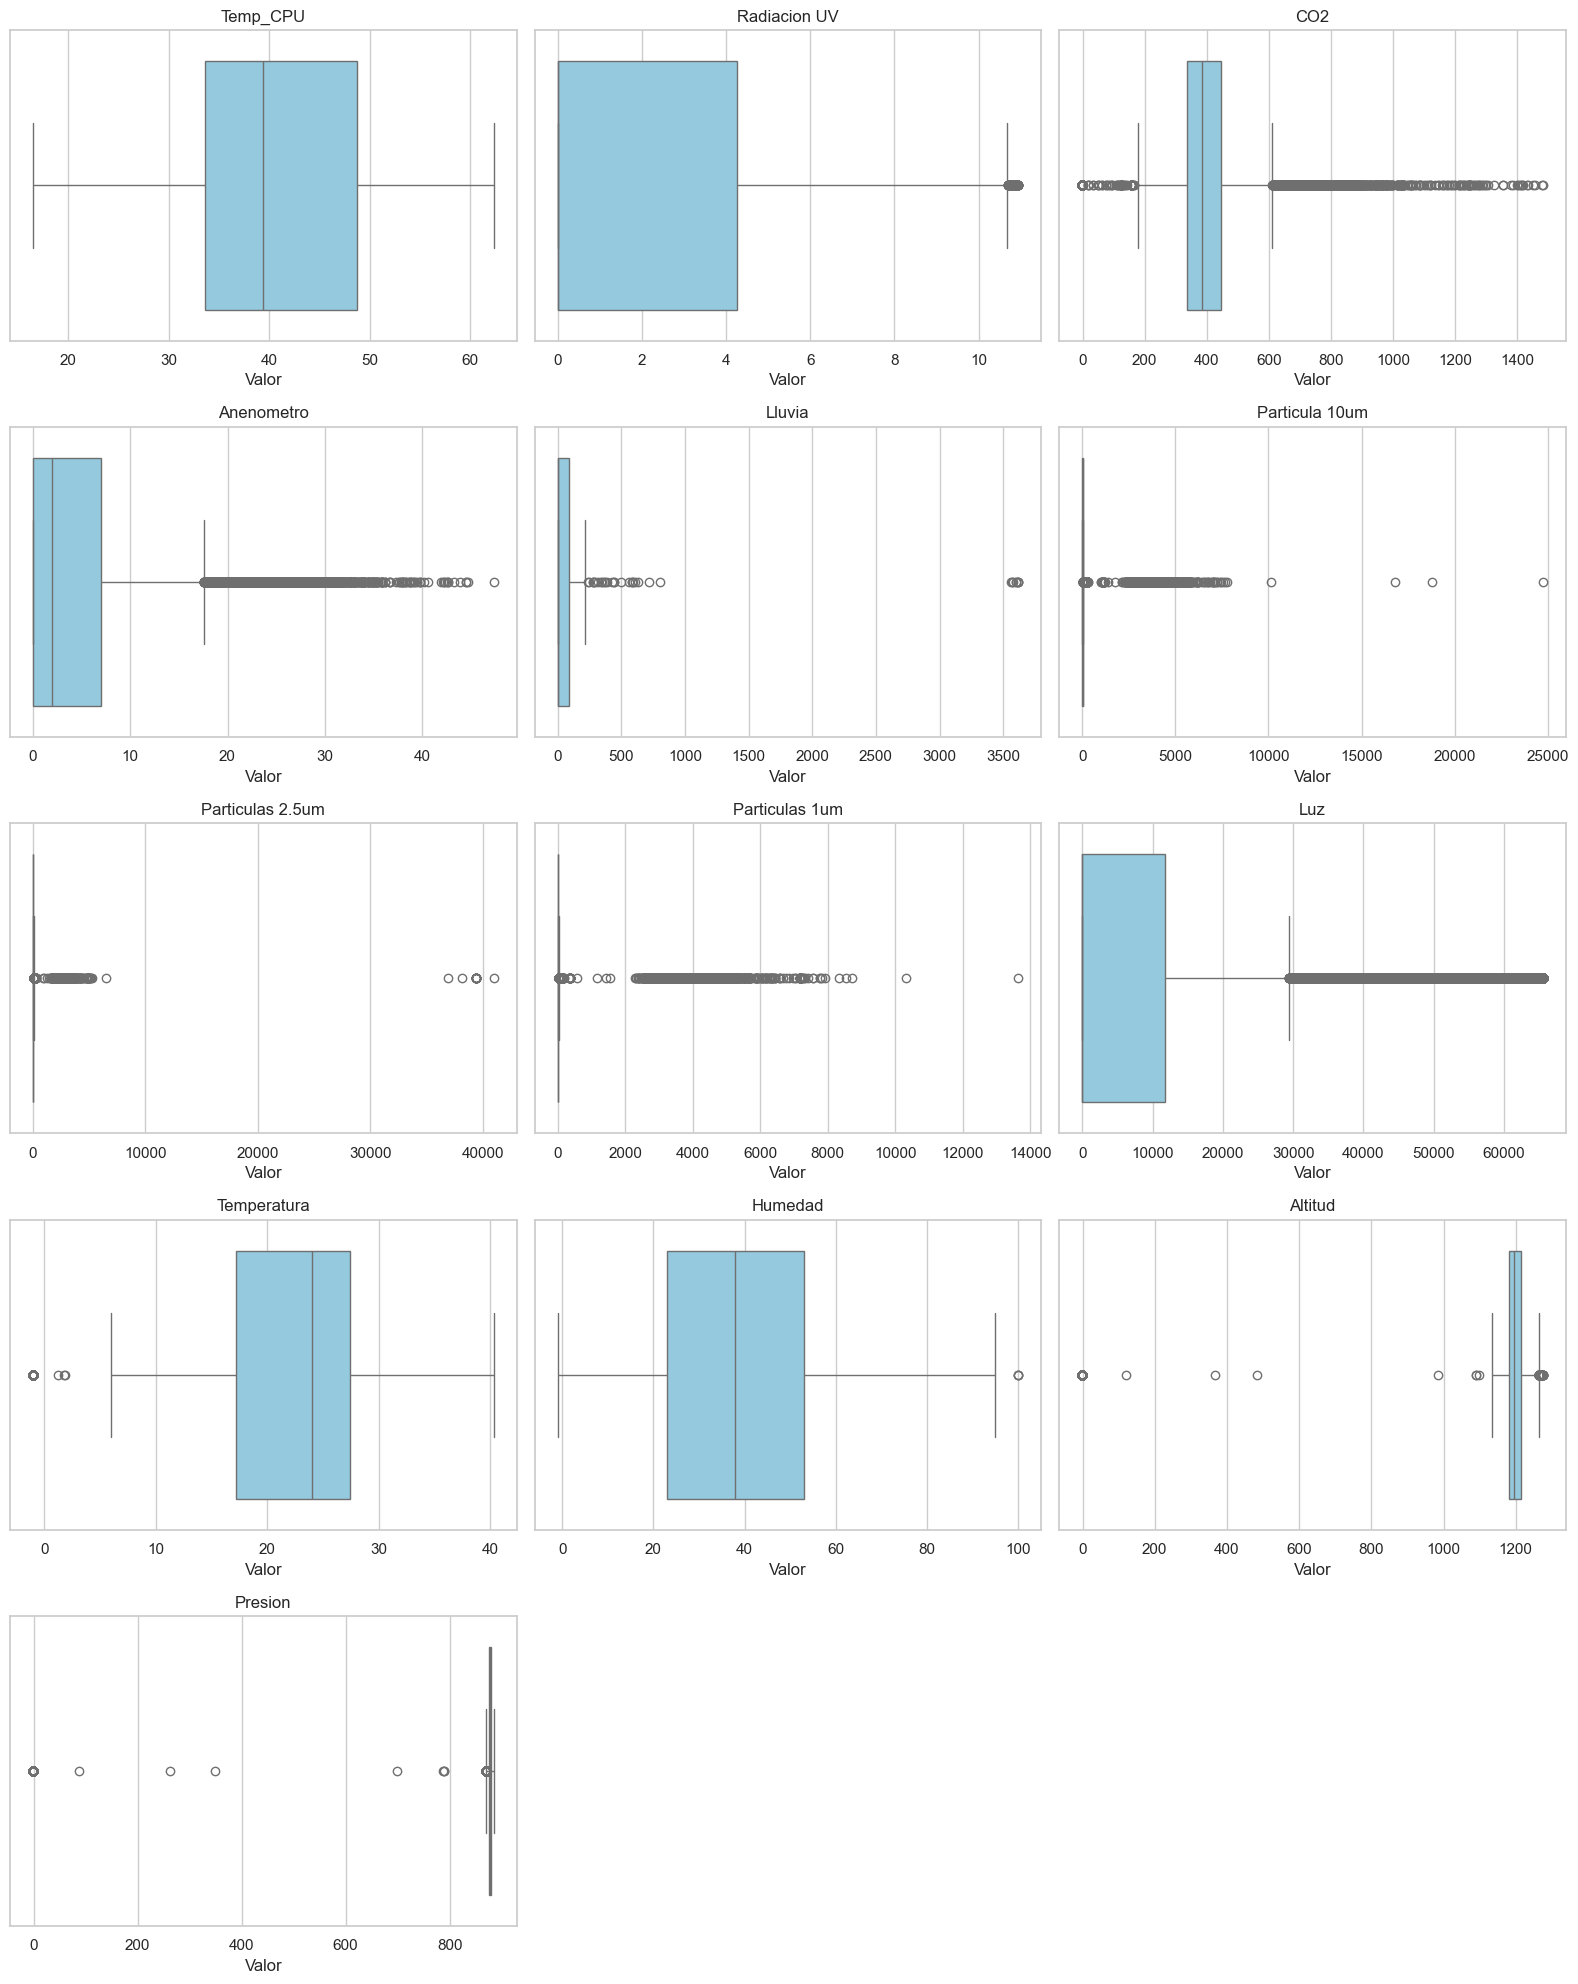

In [7]:
plt.figure(figsize=(16, 20))
for i, sensor in enumerate(sensores_numericos, 1):
    plt.subplot((len(sensores_numericos) + 2) // 3, 3, i)
    sns.boxplot(
        data=df_num[df_num["sensor_name"] == sensor],
        x="sensor_valor",
        orient="h",
        color='skyblue'
    )
    plt.title(sensor)
    plt.xlabel("Valor")

plt.tight_layout()
plt.show()


In [8]:
# Agrupar por sensor y calcular métricas para cada uno
summary_list = []

for sensor in df['sensor_name'].unique():
    valores = df[df['sensor_name'] == sensor]['sensor_valor'].dropna()
    
    if valores.empty:
        continue
    
    Q1 = valores.quantile(0.25)
    Q3 = valores.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    
    outliers_abajo = (valores < lim_inf).sum()
    outliers_arriba = (valores > lim_sup).sum()
    total_outliers = outliers_abajo + outliers_arriba
    total_valores = len(valores)
    porcentaje_outliers = (total_outliers / total_valores) * 100
    
    summary_list.append({
        "Sensor": sensor,
        "Count": total_valores,
        "Min": valores.min(),
        "Q1": Q1,
        "Mediana": valores.median(),
        "Q3": Q3,
        "Max": valores.max(),
        "IQR": IQR,
        "Lim. Inferior": lim_inf,
        "Lim. Superior": lim_sup,
        "Outliers Abajo": outliers_abajo,
        "Outliers Arriba": outliers_arriba,
        "Outliers (%)": round(porcentaje_outliers, 2)
    })

# Crear DataFrame resumen
df_outliers = pd.DataFrame(summary_list)

# Ordenar por porcentaje de outliers descendente
df_outliers = df_outliers.sort_values(by="Outliers (%)", ascending=False)

# Mostrar tabla
import pandas as pd
pd.set_option('display.max_rows', None)
display(df_outliers)


,Sensor,Count,Min,Q1,Mediana,Q3,Max,IQR,Lim. Inferior,Lim. Superior,Outliers Abajo,Outliers Arriba,Outliers (%)
2,CO2,34685,-1.0,337.9,383.20,447.30,1481.50,109.40,173.800,611.400,4507,2660,20.66
8,Luz,34685,-1.0,0.0,2.20,11753.10,65492.00,11753.10,-17629.650,29382.750,0,6468,18.65
5,Particula 10um,34685,-1.0,8.0,17.50,30.60,24729.60,22.60,-25.900,64.500,0,5243,15.12
7,Particulas 1um,34685,-1.0,5.0,11.10,18.80,13640.20,13.80,-15.700,39.500,0,5108,14.73
6,Particulas 2.5um,34685,-1.0,7.0,15.80,26.70,40961.70,19.70,-22.550,56.250,0,4739,13.66
3,Anenometro,34685,0.0,0.0,2.00,7.04,47.36,7.04,-10.560,17.600,0,3031,8.74
1,Radiacion UV,34685,0.0,0.0,0.02,4.27,10.94,4.27,-6.405,10.675,0,2058,5.93
9,Temperatura,34685,-1.0,17.2,24.00,27.40,40.30,10.20,1.900,42.700,403,0,1.16
12,Presion,34685,-1.0,875.7,877.60,879.20,884.30,3.50,870.450,884.450,396,0,1.14
11,Altitud,34685,-1.0,1180.4,1195.80,1213.60,1274.80,33.20,1130.600,1263.400,265,127,1.13


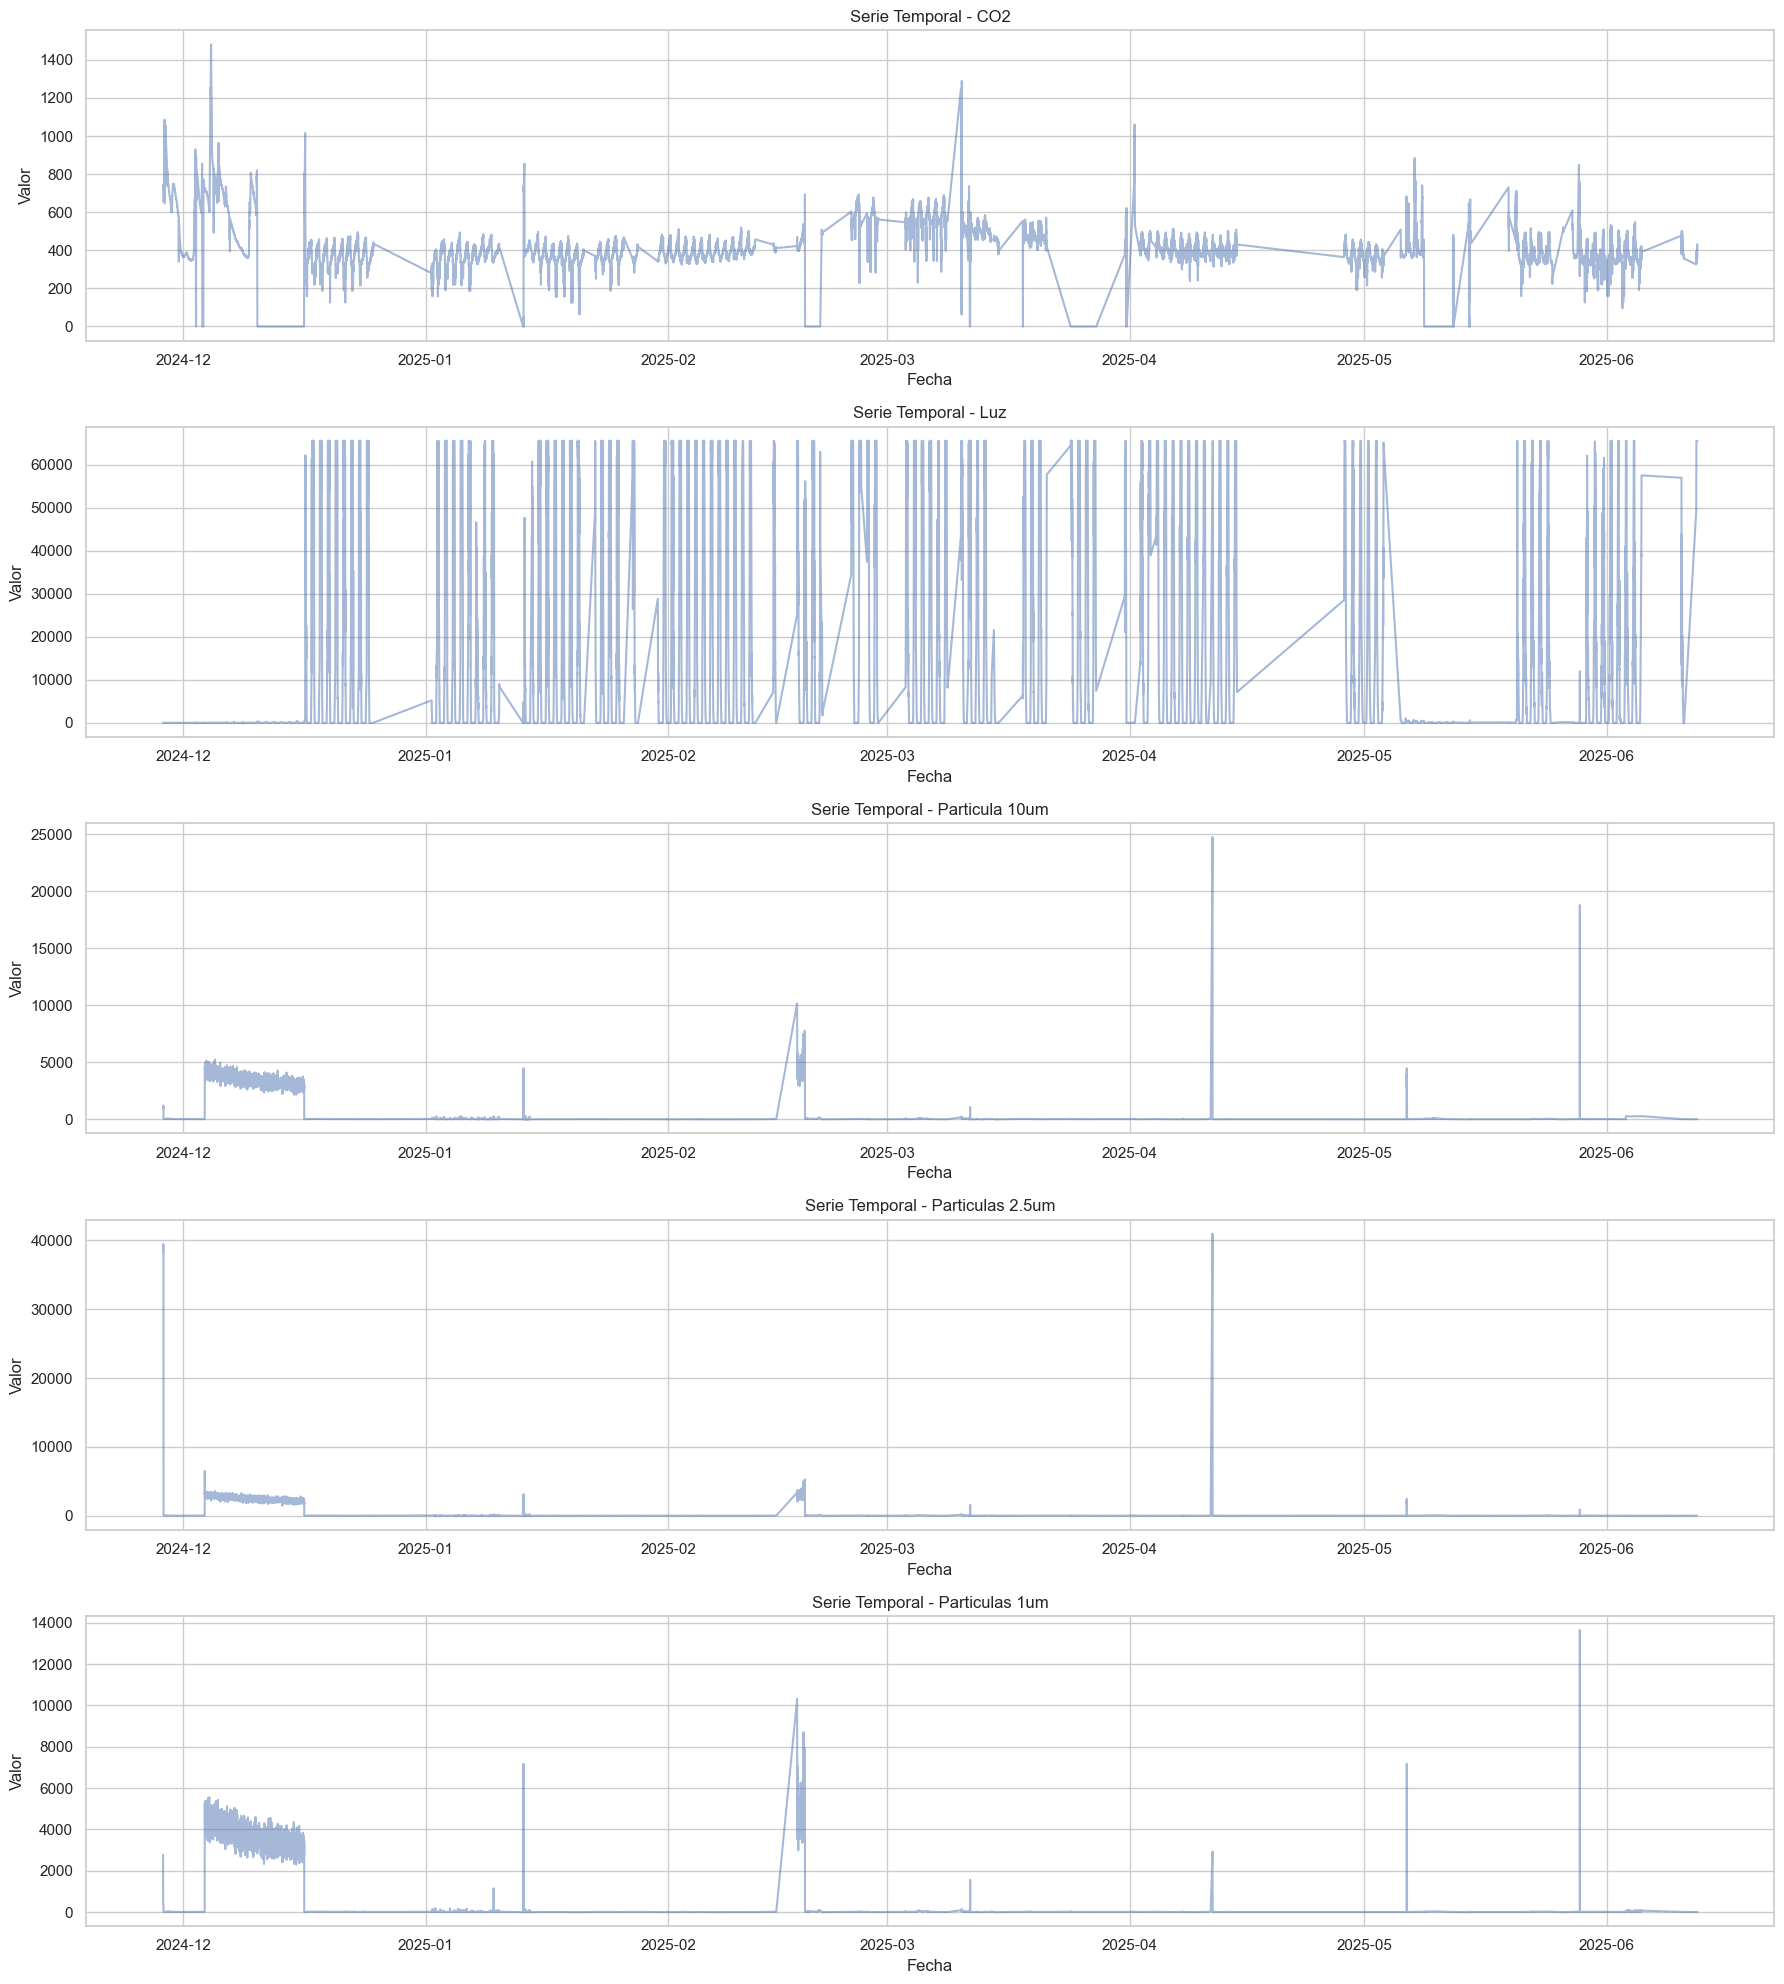

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegura orden temporal
df = df.sort_values("fecha")

# Lista de sensores con más outliers
sensores_outliers = ['CO2', 'Luz', 'Particula 10um', 'Particulas 2.5um', 'Particulas 1um']

# Tamaño general del plot
plt.figure(figsize=(18, 20))

for i, sensor in enumerate(sensores_outliers, 1):
    plt.subplot(len(sensores_outliers), 1, i)
    datos = df[df['sensor_name'] == sensor]
    plt.plot(datos['fecha'], datos['sensor_valor'], alpha=0.5)
    plt.title(f"Serie Temporal - {sensor}")
    plt.ylabel("Valor")
    plt.xlabel("Fecha")
    plt.tight_layout()

plt.show()


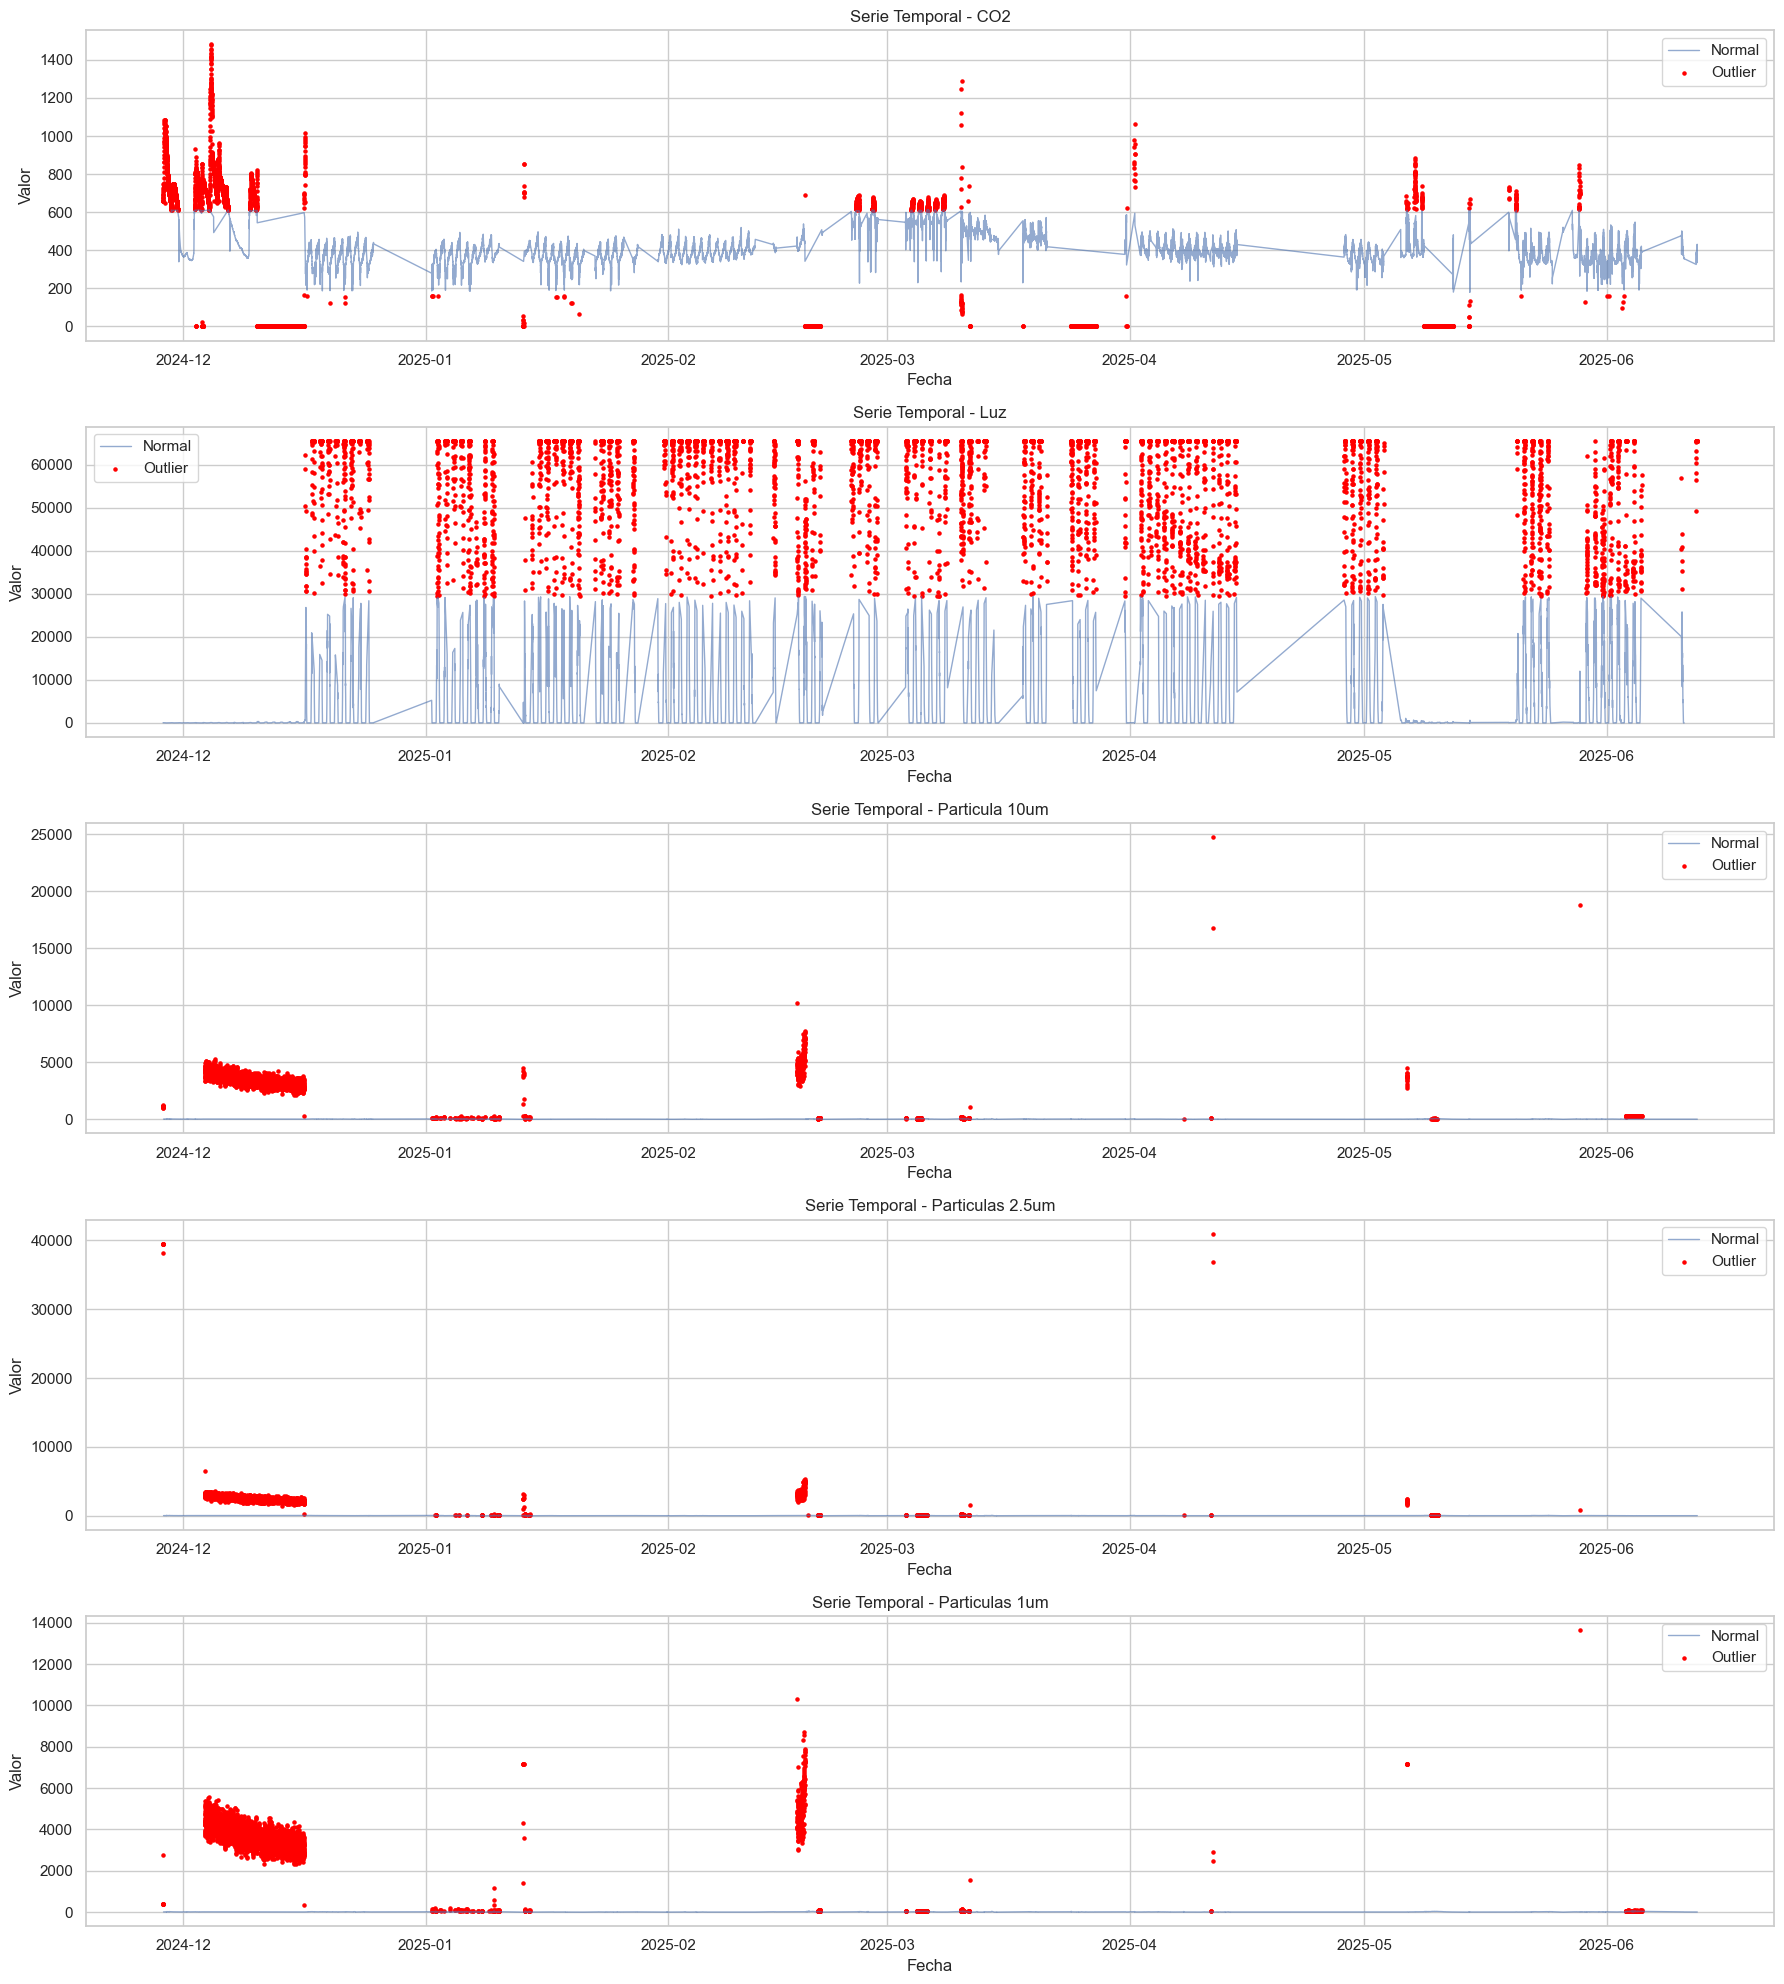

In [ ]:
import matplotlib.pyplot as plt

# Diccionario con los límites IQR por sensor
limites_iqr = {
    'CO2': (173.8, 611.4),
    'Luz': (-17629.65, 29382.75),
    'Particula 10um': (-25.9, 64.5),
    'Particulas 2.5um': (-22.55, 56.25),
    'Particulas 1um': (-15.7, 39.5)
}

# Sensores a graficar
sensores_outliers = list(limites_iqr.keys())

plt.figure(figsize=(18, 20))

for i, sensor in enumerate(sensores_outliers, 1):
    plt.subplot(len(sensores_outliers), 1, i)
    datos = df[df['sensor_name'] == sensor].sort_values("fecha")

    # Límites de IQR
    lim_inf, lim_sup = limites_iqr[sensor]

    # Separar normales y outliers
    normales = datos[(datos['sensor_valor'] >= lim_inf) & (datos['sensor_valor'] <= lim_sup)]
    outliers = datos[(datos['sensor_valor'] < lim_inf) | (datos['sensor_valor'] > lim_sup)]

    # Graficar normales
    plt.plot(normales['fecha'], normales['sensor_valor'], label='Normal', alpha=0.6, linewidth=1)

    # Graficar outliers
    plt.scatter(outliers['fecha'], outliers['sensor_valor'], color='red', label='Outlier', s=5)

    plt.title(f"Serie Temporal - {sensor}")
    plt.ylabel("Valor")
    plt.xlabel("Fecha")
    plt.legend()
    plt.tight_layout()

plt.show()


In [13]:
# Asegurarnos de que 'fecha' esté en formato datetime y ordenado
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')

# Filtrar solo los sensores con datos numéricos válidos
df_num = df[df['sensor_valor'].notnull()]

# Pivotear: cada fila será una fecha, y cada columna un sensor
df_pivot = df_num.pivot(index='fecha', columns='sensor_name', values='sensor_valor')


In [14]:
# Calcular matriz de correlación
correlation_matrix = df_pivot.corr()


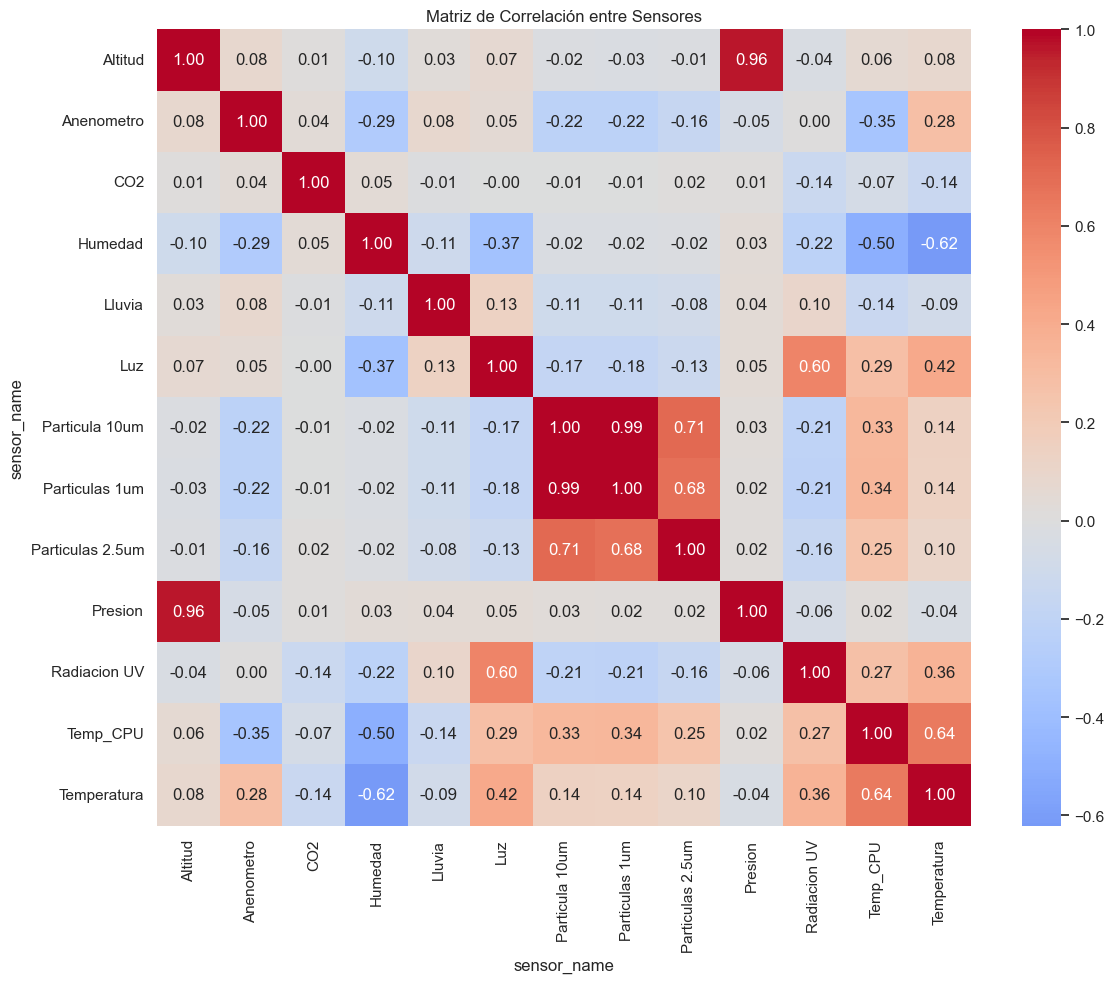

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de Correlación entre Sensores")
plt.tight_layout()
plt.show()


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Usamos el DataFrame pivotado que tiene sensores como columnas y fecha como índice
scaler = MinMaxScaler()

# Aplicar normalización min-max a cada columna (sensor)
df_normalizado = pd.DataFrame(
    scaler.fit_transform(df_pivot),
    columns=df_pivot.columns,
    index=df_pivot.index
)


<Axes: title={'center': 'Series normalizadas'}, xlabel='fecha'>

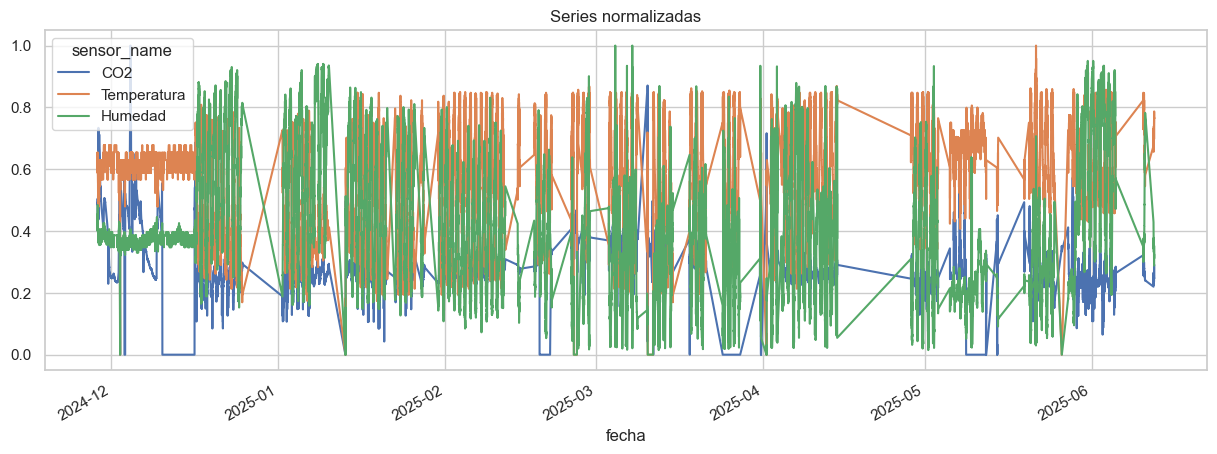

In [17]:
df_normalizado[['CO2', 'Temperatura', 'Humedad']].plot(figsize=(15, 5), title='Series normalizadas')
